**CS 8001: Designing End-to-End ML System**

In [114]:
from datasets import load_dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import pytesseract
import re

In [115]:
ds = load_dataset("lansinuote/ocr_id_card")

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x500 at 0x1EE7D7E9AE0>
(500, 500, 3)
(500, 500)


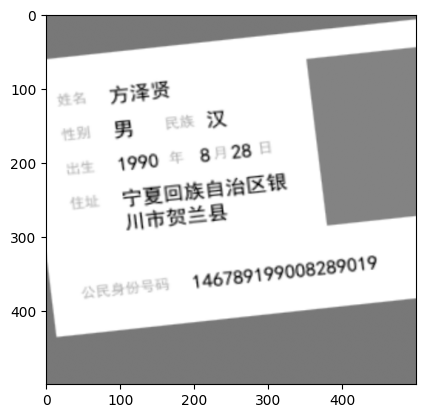

In [116]:
testingImage = ds['train'][2]['image']
print(testingImage)
#testingImage.show()
testingImageArray = np.array(testingImage)
print(testingImageArray.shape)
edgeDetectionArray = cv2.cvtColor(testingImageArray, cv2.COLOR_RGB2GRAY)
print(edgeDetectionArray.shape)
plt.imshow(edgeDetectionArray, cmap='gray')
#plt.show()


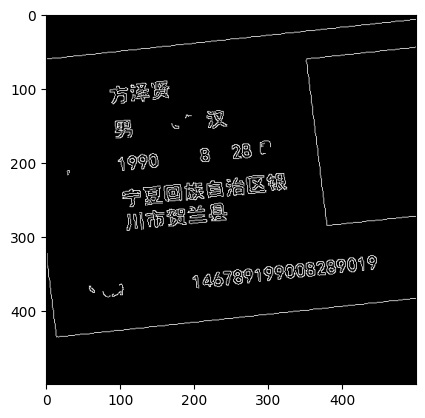

In [117]:
edges = cv2.Canny(edgeDetectionArray, 100, 200)
plt.imshow(edges, cmap='gray')
plt.show()

[[[  1  60 499   7]]

 [[ 92 427 499 384]]

 [[352  61 379 285]]

 [[216 353 446 329]]

 [[246 352 446 330]]

 [[ 14 436 280 408]]

 [[103 244 323 228]]

 [[202 359 444 338]]

 [[203 366 443 341]]

 [[246 353 446 336]]

 [[134 255 253 243]]

 [[288 361 400 349]]

 [[117 240 289 228]]

 [[131 235 202 228]]

 [[326 338 442 326]]

 [[352  60 498  45]]

 [[203 361 429 341]]

 [[236 228 322 220]]

 [[237 230 315 225]]

 [[136 249 325 236]]

 [[104 240 258 224]]

 [[380 285 499 273]]

 [[253 352 446 332]]

 [[110 246 321 231]]

 [[103 247 218 239]]

 [[218 351 444 328]]]


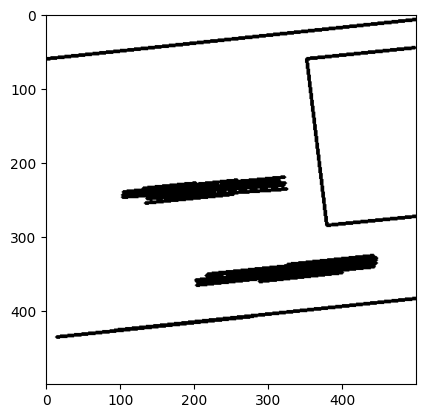

In [118]:
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 75, None, 50, 10)
print(lines)
linesTest = np.zeros(edges.shape) + 250
for i in range(0, len(lines)):
    l = lines[i][0]
    cv2.line(linesTest, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
plt.imshow(linesTest, cmap='gray')
plt.show()

In [119]:
# find the least horizontal of horizontal lines of the lines to use for orientation
# this way we know there isn't an issue with the text lines
theta = np.zeros(len(lines))
for i in range(0, len(lines)):
    l = lines[i][0]
    theta[i] = math.atan(abs(l[2] - l[0])/abs(l[3] - l[1]))

# find smallest angle greater than pi/4
print(theta)
optTheta = 100
optIndex = 0
for k in range(len(theta)):
    if theta[k] > np.pi/4:
        if theta[k] < optTheta:
            optTheta = theta[k]
            optIndex = k
mostHorz = np.float32(lines[optIndex][0])
print(optIndex, mostHorz)

[1.46476972 1.46553571 0.119957   1.46682477 1.4612368  1.46591939
 1.49819687 1.4842363  1.46700399 1.48600015 1.47029573 1.46406065
 1.50114175 1.47252237 1.46771472 1.46841582 1.48253069 1.47804001
 1.50678135 1.50212142 1.46727165 1.47029573 1.46753795 1.49982568
 1.501343   1.4693756 ]
4 [246. 352. 446. 330.]


In [120]:
# find points for the warping
mdpnt = [(mostHorz[0] + mostHorz[2])/2,(mostHorz[1] + mostHorz[3])/2]
print(mostHorz)
print(mdpnt)
adjustment = 100
if mdpnt[1] > 250:
    initialPts = np.float32([[mostHorz[0], mostHorz[1]],
                             [mostHorz[2], mostHorz[3]],
                             [mdpnt[0], mdpnt[1] - adjustment]])
    finalPts = np.float32([[mostHorz[0], mdpnt[1]],
                           [mostHorz[2], mdpnt[1]],
                           [mdpnt[0], mdpnt[1] - adjustment]])
else:
    initialPts = np.float32([[mostHorz[0], mostHorz[1]],
                             [mostHorz[2], mostHorz[3]],
                             [mdpnt[0], mdpnt[1] + adjustment]])
    finalPts = np.float32([[mostHorz[0], mdpnt[1]],
                           [mostHorz[2], mdpnt[1]],
                           [mdpnt[0], mdpnt[1] + adjustment]])
print(initialPts)

[246. 352. 446. 330.]
[np.float32(346.0), np.float32(341.0)]
[[246. 352.]
 [446. 330.]
 [346. 241.]]


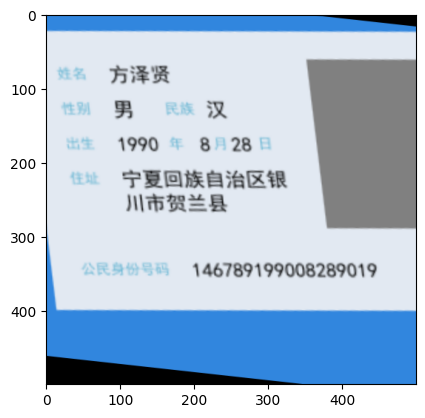

In [121]:
# do the warping
M = cv2.getAffineTransform(initialPts, finalPts)
warpedImg = cv2.warpAffine(testingImageArray, M, (testingImageArray.shape[1], testingImageArray.shape[0]))
plt.imshow(warpedImg)
plt.show()

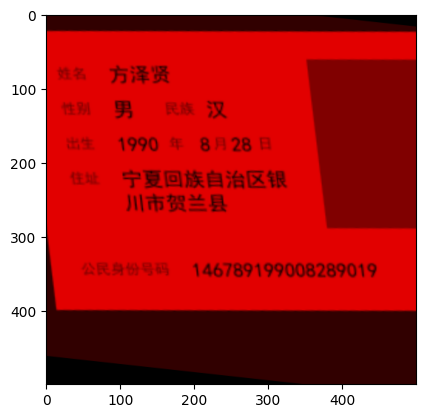

In [122]:
# red channel isolation:
#print(warpedImg.shape[0])
redshiftImg = warpedImg
for m in range(warpedImg.shape[0]):
    for n in range(warpedImg.shape[1]):
        redshiftImg[m][n][1] = 0
        redshiftImg[m][n][2] = 0

plt.imshow(redshiftImg)
plt.show()
# that was easy

In [123]:
# okay OCR time
wordsRaw = pytesseract.image_to_string(redshiftImg, lang='chi_sim')
print(wordsRaw)


沥 沥 沥 沥 沥
姑 吊 “ 方 泽 贾
M 男 “ 族 汉

5 生 “1990 年 8 月 28 {

宁 夏 回 族 自 治 区 银
川 市 贺 兰 县

146789199008289019




In [124]:


words = wordsRaw.replace(" ","").splitlines()
testingData = ds['train'][2]['ocr']
print(len(testingData))
print(testingData)

pattern = r'\d+|[\u4e00-\u9fff]+|[A-Za-z]+|\s|[^\w\s]'
tokens = []
for i in range(len(words)):
    tokens.append(re.findall(pattern, words[i]))
print(tokens)
print(words)

8
[{'box': [78.68572706018443, 82.48091794718644, 172.8572486351825, 127.51479593237991], 'cls': 0, 'word': '方泽贤'}, {'box': [84.45516705337403, 135.01968550679487, 122.99015687154693, 175.8886490040849], 'cls': 1, 'word': '男'}, {'box': [210.15661310561754, 121.46242908549918, 248.69160292379055, 162.33139258278925], 'cls': 2, 'word': '汉'}, {'box': [90.68616224601877, 182.02615319340356, 157.99617979227847, 216.82037083398913], 'cls': 3, 'word': '1990'}, {'box': [200.4255199106758, 174.70953861683128, 225.835055439521, 204.98467078365164], 'cls': 4, 'word': '8'}, {'box': [244.32126297653866, 168.68409131847764, 281.7023647960737, 200.25039076351666], 'cls': 5, 'word': '28'}, {'box': [96.22482463948081, 207.74182056366814, 343.9641440434711, 300.5443473042479], 'cls': 6, 'word': '宁夏回族自治区银川市贺兰县'}, {'box': [189.04054951125786, 318.13192047081185, 452.34770500490714, 377.73626927653567], 'cls': 7, 'word': '146789199008289019'}]
[['沥沥沥沥沥'], ['姑吊', '“', '方泽贾'], ['M', '男', '“', '族汉'], [], ['5'

In [125]:
# okay time for some actual functionality: let's make an accuracy checker

def accuracyChecker(words, testData):
    accuracy = 0
    dataUse = [testData[0]['word'], testData[1]['word'],
               testData[2]['word'], testData[3]['word'],
               testData[4]['word'], testData[5]['word'],
               testData[6]['word'][:8], testData[6]['word'][8:], testData[7]['word']]
    for i in range(len(words)):
        for j in range(len(words[i])):
            for k in range(len(dataUse)):
                if not dataUse[k].isdigit() and len(dataUse[k]) == 1:
                    if dataUse[k] in words[i][j]:
                        accuracy += 1
                else:
                    if words[i][j] == dataUse[k]:
                        accuracy += 1

    if dataUse[7] == '':
        return accuracy / 8
    else:
        return accuracy / 9


In [131]:
# okay gonna run all the data through the whole pipeline, this should make it possible to change a pipeline and compute average accuracy of that pipeline

accuracy = []
numImages = len(ds['train'])
numImages = 100
for imgNum in range(numImages):
    # collect an image from the dataset and turn it into an array for edge detection, use greyscale
    currImg = ds['train'][imgNum]['image']
    testingImageArray = np.array(currImg)
    edgeDetectionArray = cv2.cvtColor(testingImageArray, cv2.COLOR_RGB2GRAY)

    # apply canny edge detection
    edges = cv2.Canny(edgeDetectionArray, 100, 200)

    # do a hough lines transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 75, None, 50, 10)
    linesTest = np.zeros(edges.shape) + 250
    for i in range(0, len(lines)):
        l = lines[i][0]
        cv2.line(linesTest, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

    # find the angles at which each line lies
    theta = np.zeros(len(lines))
    for i in range(0, len(lines)):
        l = lines[i][0]
        if abs(l[3] - l[1]) == 0:
            # horizontal line
            theta[i] = 0
        else:
            theta[i] = math.atan(abs(l[2] - l[0])/abs(l[3] - l[1]))

    # find smallest angle greater than pi/4
    optTheta = 100
    optIndex = 0
    for k in range(len(theta)):
        if theta[k] > np.pi/4:
            if theta[k] < optTheta:
                optTheta = theta[k]
                optIndex = k
    mostHorz = np.float32(lines[optIndex][0])
    # this actually ends up being the least horizontal of the still pretty horizontal lines, deals with noise from extra lines created from the text

    # find some points to warp the image, use the midpoint of the lines offset a bit, and the new destination of the endpoints of the least horizontal but still horizontal line
    mdpnt = [(mostHorz[0] + mostHorz[2])/2,(mostHorz[1] + mostHorz[3])/2]
    adjustment = 100
    if mdpnt[1] > 250:
        initialPts = np.float32([[mostHorz[0], mostHorz[1]],
                                 [mostHorz[2], mostHorz[3]],
                                 [mdpnt[0], mdpnt[1] - adjustment]])
        finalPts = np.float32([[mostHorz[0], mdpnt[1]],
                               [mostHorz[2], mdpnt[1]],
                               [mdpnt[0], mdpnt[1] - adjustment]])
    else:
        initialPts = np.float32([[mostHorz[0], mostHorz[1]],
                                 [mostHorz[2], mostHorz[3]],
                                 [mdpnt[0], mdpnt[1] + adjustment]])
        finalPts = np.float32([[mostHorz[0], mdpnt[1]],
                               [mostHorz[2], mdpnt[1]],
                               [mdpnt[0], mdpnt[1] + adjustment]])

    # warp it
    M = cv2.getAffineTransform(initialPts, finalPts)
    warpedImg = cv2.warpAffine(testingImageArray, M, (testingImageArray.shape[1], testingImageArray.shape[0]))

    # red it
    redshiftImg = warpedImg
    for m in range(warpedImg.shape[0]):
        for n in range(warpedImg.shape[1]):
            redshiftImg[m][n][1] = 0
            redshiftImg[m][n][2] = 0

    # tesseract it
    wordsRaw = pytesseract.image_to_string(redshiftImg, lang='chi_sim')

    # clean and tokenize the data from OCR
    words = wordsRaw.replace(" ","").splitlines()
    testingData = ds['train'][imgNum]['ocr']

    pattern = r'\d+|[\u4e00-\u9fff]+|[A-Za-z]+|\s|[^\w\s]'
    tokens = []
    for i in range(len(words)):
        tokens.append(re.findall(pattern, words[i]))

    # run the accuracy checker on the final data
    accuracy.append(accuracyChecker(tokens, testingData))

print(np.mean(accuracy))


0.43125
